# Data Exploration: Point Trajectory

Exploring the trajectory of each facial point caputred by nuiCapture as a candidate feature.

<p>
    <img src="nuicapture.png">
    <em>Source: CadavidConcepts</em>
</p>

In [1]:
import glob as gl
import numpy as np
from scipy.io import loadmat
from typing import List
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
def labelname(file_name):
    label = file_name.replace("data/points/sample", "").lower()
    return label.replace(".mat", "")


class Signal:
    def __init__(self, x, y, label):
        self.x = x
        self.y = y
        self.label = label

def trajectory(sig):
    points_x = np.array(np.split(sig.x, 121, axis=1))
    points_y = np.array(np.split(sig.y, 121, axis=1))
    
    npoints, nrecs, nframes = np.shape(points_x)
    
    distances = np.empty((nrecs, npoints))
    
    # TO DO: normalizar
    # Calcula distância euclidiana entre (x,y) do frame atual e (x,y) do próximo frame
    # Resultado é registrado como soma acumulada das distâncias percorridas por cada ponto entre frames
    for r in range(nrecs):
        for p in range(npoints):
            distances[r][p] = 0
            for f in range(nframes-1):
                current_frame = [points_x[p, r, f], points_y[p, r, f]]
                next_frame = [points_x[p, r, f+1], points_y[p, r, f+1]]
                distances[r][p] += distance.euclidean(current_frame, next_frame)

    # Imprime 20 primeiros pontos com maiores distâncias acumuladas
    print("Label: ", sig.label)
    print((pd.DataFrame(data=(-np.sort(-distances, axis=1, )))).loc[:,0:20]) 
    print()
    
    return np.argsort(-distances, axis=1)

In [3]:
files = gl.glob("data/points/*.mat")  # type: list
signals = []  # type: List[Signal]

for f in files:
    data = loadmat(f).get('pontosSinal')
    signals.append(Signal(data[:, ::2], data[:, 1::2], labelname(f)))

nsigns = len(signals)
nrecs, n_x = np.shape(signals[0].x)  # Number of recordings and number of features
nframes = 5

signals_feat = []  # Updated signals, according to each experiment
signals_labels = []
labels_dict = {}  # Dictionary of signals' labels, for reference
i = 0

for s in signals:
    signals_feat.append(trajectory(s))
    signals_labels.append([i] * nrecs)
    labels_dict[i] = s.label
    i += 1

sig_features = pd.DataFrame(data=np.vstack(signals_feat)) # 100 x 121
sig_labels = np.reshape(signals_labels, (nsigns * nrecs,))

Label:  acalmar
         0         1         2         3         4         5         6   \
0  0.354850  0.354451  0.354155  0.353857  0.336959  0.310080  0.298780   
1  0.343690  0.343217  0.341420  0.341242  0.326544  0.300296  0.292174   
2  0.343916  0.334798  0.333095  0.333076  0.326358  0.299848  0.290989   
3  0.377558  0.376505  0.376236  0.375933  0.356459  0.328365  0.321313   
4  0.363606  0.363474  0.363426  0.363111  0.344795  0.317460  0.306219   
5  0.354499  0.354344  0.354260  0.354260  0.336810  0.309438  0.300255   
6  0.377577  0.377551  0.377465  0.369764  0.357513  0.331476  0.328777   
7  0.369897  0.368884  0.368698  0.362450  0.350891  0.323370  0.311359   
8  0.351441  0.350928  0.350764  0.346743  0.333674  0.305611  0.298284   
9  0.377622  0.356412  0.355186  0.355058  0.338243  0.316003  0.311194   

         7         8         9     ...           11        12        13  \
0  0.296513  0.292409  0.290112    ...     0.289050  0.286847  0.285734   
1  0.290

In [4]:
# Índices dos 10% pontos de maior distância acumulada

for i in range(nsigns):
    print(signals[i].label)
    result = sig_features.loc[i*10:(i*10+9), 0:11]
    print(result)
    print()
    


acalmar
   0    1    2    3   4   5   6   7    8    9    10   11
0  19   92   68  116  44  43  20  81   57   71  120   23
1  19   68  116   92  44  43  81  20  120   71   23   47
2  19   68  116   92  44  43  20  81    2   47  120   23
3  19   92   68  116  44  43  81  20    2   47   71  120
4  92   68   19  116  44  43  20  81  120   23   47   71
5  19  116   92   68  44  43  20   2   71  120   47   66
6  68   19   92  116  44  43  81  20    2   26   47   23
7  19   92   68  116  44  43  20  57   81   71   23   50
8  19   68   92  116  44  43  20  81   57   71   47   23
9  19   68  116   92  44  20  43   2   81   23  120   71

acusar
    0    1    2    3    4   5   6   7   8    9   10   11
10  19  116   92   68   44  81  57  43  20   26  50  105
11  19  116   92   44   81  68  57  20  26   43   2   23
12  19  116   68   92   44  81  57  43  26   20  50  105
13  19  116   68   92   44  81  43  57  26    2  20   50
14  19   68   92  116   44  81  43  57  26   20   2  105
15  68   19  11

In [5]:
# Moda dos 10% pontos de maior distância acumulada para cada sinal
# Gravações que mais se diferenciam da moda
# Número de pontos diferentes da moda

for i in range(nsigns):
    print("Signal: ", signals[i].label)
    result_sorted = pd.DataFrame(np.sort(np.array(sig_features.loc[i*10:(i*10+9), 0:11]), axis=1))
    result_mode = result_sorted.mode(axis=0).loc[0,:]
    print("Mode: ", np.array(result_mode.astype(int)))
    distance_mode = abs(result_sorted-result_mode)/abs(result_sorted-result_mode)
    distance_mode.fillna(0, inplace=True)
    index = distance_mode.sum(axis=1).sort_values(ascending=False).head(3).index
    print("Most distant from mode: ", np.sort(np.array(index)))
    print(distance_mode.sum(axis=1).astype(int))
    print()
    


Signal:  acalmar
Mode:  [  2  19  20  43  44  47  68  71  81  92 116 120]
Most distant from mode:  [6 7 8]
0     4
1     3
2     5
3     0
4     3
5     3
6     9
7    10
8     9
9     3
dtype: int64

Signal:  acusar
Mode:  [  2  19  20  26  43  44  57  57  68  81  92 116]
Most distant from mode:  [0 2 8]
0    10
1     4
2    10
3     1
4     4
5     4
6     4
7     4
8     4
9     1
dtype: int64

Signal:  aniquilar
Mode:  [  2  19  20  26  43  44  50  57  68  81  92 116]
Most distant from mode:  [4 7 9]
0     5
1     0
2     4
3     0
4     5
5     0
6     0
7    11
8     0
9     5
dtype: int64

Signal:  apaixonado
Mode:  [  2  19  20  26  43  44  57  57  68  81  92 116]
Most distant from mode:  [1 2 7]
0    2
1    7
2    7
3    1
4    1
5    1
6    1
7    7
8    2
9    1
dtype: int64

Signal:  engordar
Mode:  [  2  19  20  26  43  44  57  57  68  81  92 116]
Most distant from mode:  [3 5 8]
0    1
1    1
2    1
3    5
4    4
5    4
6    2
7    2
8    4
9    2
dtype: int64

Signal:  f

<IPython.core.display.Javascript object>


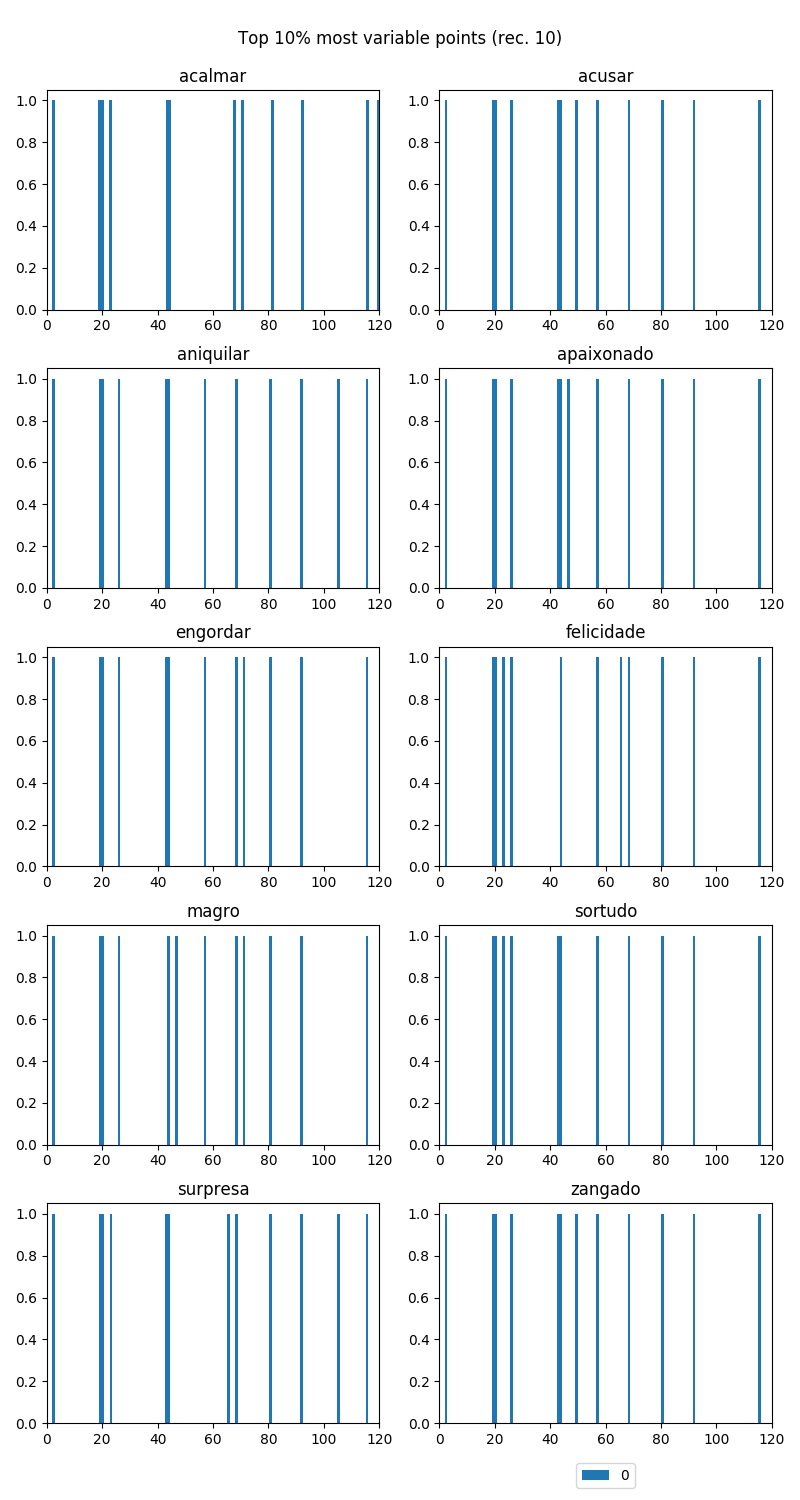

In [8]:
ax = []
fig, axes = plt.subplots(nrows=5, ncols=2)
ax = axes.flatten()

for i in range(len(ax)):
    ax[i].hist(sig_features.loc[i*10+9, 0:11], bins=121, label=range(11))
    ax[i].set_title(signals[i].label)
    ax[i].set_xlim([0, 120])

fig.suptitle('Top 10% most variable points (rec. 10)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),ncol=5)
plt.rcParams['figure.figsize'] = [8, 15]
fig.tight_layout()
fig.subplots_adjust(top=0.94)
plt.show()